# Let us visualize how Clay reconstructs each sensor from 70% masked inputs

In [2]:
import sys
import warnings

sys.path.append("../..")
warnings.filterwarnings(action="ignore")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from claymodel.datamodule import ClayDataModule
from claymodel.module import ClayMAEModule

In [4]:
DATA_DIR = "/home/ubuntu/data"
CHECKPOINT_PATH = "../../checkpoints/clay-v1.5.ckpt"
METADATA_PATH = "../../configs/metadata.yaml"
CHIP_SIZE = 256
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
MASK_RATIO = 0.7  # 70% masking of inputs

### MODEL

Load the model with best checkpoint path and set it in eval mode. Set mask_ratio to `70%` & shuffle to `True`.

In [4]:
module = ClayMAEModule.load_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    model_size="large",
    metadata_path="../../configs/metadata.yaml",
    dolls=[16, 32, 64, 128, 256, 768, 1024],
    doll_weights=[1, 1, 1, 1, 1, 1, 1],
    mask_ratio=0.7,
    shuffle=True,
)

module.eval();

## Distributed Setup

In [5]:
import os

import torch.distributed as dist

if not dist.is_initialized():
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"  # Can be any free port
    dist.init_process_group("nccl", rank=0, world_size=1)

## DATAMODULE

Load the ClayDataModule

In [6]:
# For model training, we stack chips from one sensor into batches of size 128.
# This reduces the num_workers we need to load the batches and speeds up the
# training process. Here, although the batch size is 1, the data module reads
# batch of size 128.
dm = ClayDataModule(
    data_dir=DATA_DIR,
    metadata_path=METADATA_PATH,
    size=CHIP_SIZE,
    batch_size=1,
    num_workers=1,
)
dm.setup(stage="fit")

Total number of chips: 258


Let us look at the data directory.

We have a folder for each sensor, i.e:
- Landsat l1
- Landsat l2
- Sentinel 1 rtc
- Sentinel 2 l2a
- Naip
- Linz
- Modis

And, under each folder, we have stacks of chips as `.npz` files.

In [7]:
!tree -L 1 {DATA_DIR}

/home/ubuntu/data
├── landsat-c2l1
├── landsat-c2l2-sr
├── linz
├── modis
├── naip
├── sentinel-1-rtc
└── sentinel-2-l2a

7 directories, 0 files


In [8]:
!tree -L 2 {DATA_DIR}/naip | head -5

/home/ubuntu/data/naip
├── cube_10.npz
├── cube_100045.npz
├── cube_100046.npz
├── cube_100072.npz


Now, lets look at what we have in each of the `.npz` files.

In [9]:
sample = np.load("/home/ubuntu/data/naip/cube_10.npz")

In [10]:
sample.keys()

KeysView(NpzFile '/home/ubuntu/data/naip/cube_10.npz' with keys: pixels, lon_norm, lat_norm, week_norm, hour_norm)

In [11]:
sample["pixels"].shape

(128, 4, 256, 256)

In [12]:
sample["lat_norm"].shape, sample["lon_norm"].shape

((128, 2), (128, 2))

In [13]:
sample["week_norm"].shape, sample["hour_norm"].shape

((128, 2), (128, 2))

As we see above, chips are stacked in batches of size `128`.  
The sample we are looking at is from `NAIP` so it has 4 bands & of size `256 x 256`.  
We also get normalized lat/lon & timestep (hour/week) information that is *(optionally required) by the model. If you don't have this handy, feel free to pass zero tensors in their place.

Load a batch of data from ClayDataModule

ClayDataModule is designed to fetch random batches of data from different sensors sequentially, i.e batches are in ascending order of their directory - Landsat 1, Landsat 2, LINZ, NAIP, MODIS, Sentinel 1 rtc, Sentinel 2 L2A and it repeats after that. 

In [16]:
# We have a random sample subset of the data, so it's
# okay to use either the train or val dataloader.
dl = iter(dm.train_dataloader())

In [17]:
l1 = next(dl)
l2 = next(dl)
linz = next(dl)
modis = next(dl)
naip = next(dl)
s1 = next(dl)
s2 = next(dl)

In [18]:
for sensor, chips in zip(
    ("l1", "l2", "linz", "modis", "naip", "s1", "s2"),
    (l1, l2, linz, modis, naip, s1, s2),
):
    print(
        f"{chips['platform'][0]:<15}",
        chips["pixels"].shape,
        chips["time"].shape,
        chips["latlon"].shape,
    )

landsat-c2l1    torch.Size([128, 6, 256, 256]) torch.Size([128, 4]) torch.Size([128, 4])
landsat-c2l2-sr torch.Size([128, 6, 256, 256]) torch.Size([128, 4]) torch.Size([128, 4])
linz            torch.Size([128, 3, 256, 256]) torch.Size([128, 4]) torch.Size([128, 4])
modis           torch.Size([128, 7, 256, 256]) torch.Size([128, 4]) torch.Size([128, 4])
naip            torch.Size([128, 4, 256, 256]) torch.Size([128, 4]) torch.Size([128, 4])
sentinel-1-rtc  torch.Size([128, 2, 256, 256]) torch.Size([128, 4]) torch.Size([128, 4])
sentinel-2-l2a  torch.Size([128, 10, 256, 256]) torch.Size([128, 4]) torch.Size([128, 4])


## INPUT

Model expects a dictionary with keys:
- pixels:  `batch x band x height x width` - normalized chips of a sensor
- time:    `batch x 4` - horizontally stacked `week_norm` & `hour_norm`
- latlon:  `batch x 4` - horizontally stacked `lat_norm` & `lon_norm`
- waves:   `list[:band]` - wavelengths of each band of the sensor from the `metadata.yaml` file
- gsd:     `scalar` - gsd of the sensor from `metadata.yaml` file

Normalization & stacking is taken care of by the ClayDataModule: https://github.com/Clay-foundation/model/blob/f872f098224d64677ed96b6a49974bb7ddef10dc/src/datamodule.py#L55-L72

When not using the ClayDataModule, make sure you normalize the chips & pass all items for the model. 

In [19]:
def create_batch(chips, wavelengths, gsd, device):
    batch = {}

    batch["pixels"] = chips["pixels"].to(device)
    batch["time"] = chips["time"].to(device)
    batch["latlon"] = chips["latlon"].to(device)

    batch["waves"] = torch.tensor(wavelengths)
    batch["gsd"] = torch.tensor(gsd)

    return batch

### FORWARD PASS

Pass a batch from single sensor through the Encoder & Decoder of Clay.

In [20]:
# Let us see an example of what input looks like for NAIP
platform = "naip"
metadata = dm.metadata[platform]
wavelengths = list(metadata.bands.wavelength.values())
gsd = metadata.gsd
batch_naip = create_batch(naip, wavelengths, gsd, DEVICE)

In [21]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = module.model.encoder(batch_naip)
    pixels_naip, _ = module.model.decoder(
        unmsk_patch,
        unmsk_idx,
        msk_idx,
        msk_matrix,
        batch_naip["time"],
        batch_naip["latlon"],
        batch_naip["gsd"],
        batch_naip["waves"],
    )

In [22]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means)
    stds = np.array(stds)
    means = means.reshape(1, -1, 1, 1)
    stds = stds.reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means

    return denormalized_images

In [23]:
naip_mean = list(metadata.bands.mean.values())
naip_std = list(metadata.bands.std.values())

batch_naip_pixels = batch_naip["pixels"].detach().cpu().numpy()
batch_naip_pixels = denormalize_images(batch_naip_pixels, naip_mean, naip_std)
batch_naip_pixels = batch_naip_pixels.astype(np.uint8)

Rearrange the patches from the decoder back into pixel space.

Output from Clay decoder is of shape: `batch x patches x pixel_values_per_patch`, we will reshape that to `batch x channel x height x width`

In [24]:
pixels_naip = rearrange(
    pixels_naip,
    "b (h w) (c p1 p2) -> b c (h p1) (w p2)",
    c=batch_naip_pixels.shape[1],
    h=32,
    w=32,
    p1=8,
    p2=8,
)

In [25]:
denorm_pixels_naip = denormalize_images(
    pixels_naip.cpu().detach().numpy(), naip_mean, naip_std
)
denorm_pixels_naip = denorm_pixels_naip.astype(np.uint8)

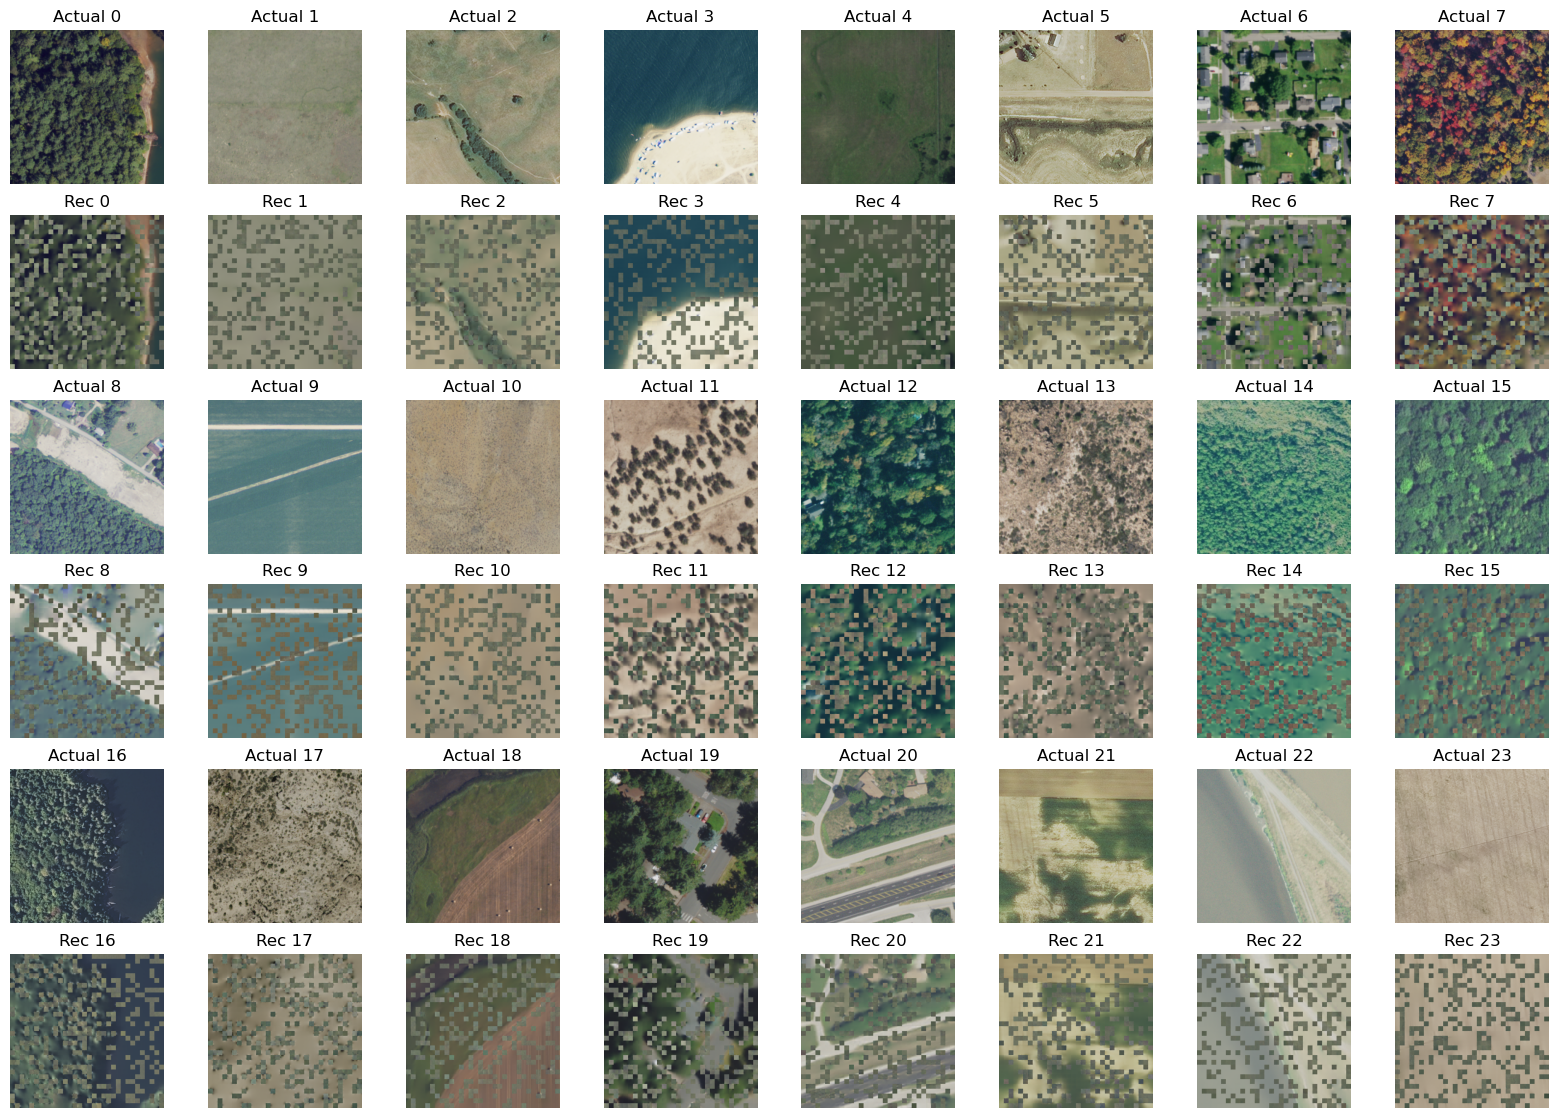

In [26]:
fig, axs = plt.subplots(6, 8, figsize=(20, 14))

for i in range(0, 6, 2):
    for j in range(8):
        idx = (i // 2) * 8 + j
        axs[i][j].imshow(batch_naip_pixels[idx, [0, 1, 2], ...].transpose(1, 2, 0))
        axs[i][j].set_axis_off()
        axs[i][j].set_title(f"Actual {idx}")
        axs[i + 1][j].imshow(denorm_pixels_naip[idx, [0, 1, 2], ...].transpose(1, 2, 0))
        axs[i + 1][j].set_axis_off()
        axs[i + 1][j].set_title(f"Rec {idx}")

### Next steps

- Look at reconstructions from other sensors
- Interpolate between embedding spaces & reconstruct images from there (create a video animation)